# Under-Representation Bias (w/ Synthetic Data)

This notebook recreates the finding that Equalized Odds constrained model can recover from under-representation bias.

### Setup

Please run the code block below to install the necessary packages (if needed).

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.base import clone

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from collections import Counter

import fairlearn
from fairlearn.metrics import *
from fairlearn.reductions import *
import aif360

import copy, random

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# Synthetic Dataset Generation

## Parameters (User Input)

In [12]:
'''

r is the proportion of training examples in the minority group, 

which means 1-r is proportion of examples in the majority group

eta is the probability of flipping the label

n is the number of training examples

beta is the probability of keeping a positively labeled example
from the minority class

NOTE: results can be replicated if and only if the following condition holds:

(1-r)(1-2*eta) + r((1-eta)*beta - eta) > 0

'''
def get_params(r = 1/3, eta = 1/4, n = 2000, beta = 0.5):
    return r, eta, n, beta

r, eta, n, beta = get_params(eta = 0.1, n = 3000)

In [13]:
# check if above constraint holds
def check_constraints(r, eta, beta):
    first = (1-r)*(1-2*eta)
    second = r * ((1-eta)*beta - eta)
    res = first + second
    print("constraint: ", res)
    print("yes!", r, eta, beta) if res > 0 else print("no", r, eta, beta)
    
bias_amts = np.divide(list(range(10, -1, -1)),10)

for beta in bias_amts:
    check_constraints(r=r, eta=eta, beta=beta)

constraint:  0.8
yes! 0.3333333333333333 0.1 1.0
constraint:  0.7700000000000001
yes! 0.3333333333333333 0.1 0.9
constraint:  0.7400000000000001
yes! 0.3333333333333333 0.1 0.8
constraint:  0.7100000000000001
yes! 0.3333333333333333 0.1 0.7
constraint:  0.6800000000000002
yes! 0.3333333333333333 0.1 0.6
constraint:  0.6500000000000001
yes! 0.3333333333333333 0.1 0.5
constraint:  0.6200000000000001
yes! 0.3333333333333333 0.1 0.4
constraint:  0.5900000000000001
yes! 0.3333333333333333 0.1 0.3
constraint:  0.56
yes! 0.3333333333333333 0.1 0.2
constraint:  0.5300000000000001
yes! 0.3333333333333333 0.1 0.1
constraint:  0.5000000000000001
yes! 0.3333333333333333 0.1 0.0


## True Label Generation

In [14]:
# create minority and majority groups
def get_cat_features(n, r):
    num_minority = int(r * n)
    num_majority = n - num_minority
    
    minority = np.zeros((num_minority, 1))
    majority = np.ones((num_majority, 1))
    
    cat_features = np.vstack((minority, majority))
    #np.random.shuffle(cat_features) # this is what causes us to not recover coeffs
    
    return cat_features

In [15]:
# return labels from Bayes Optimal Classifier
def get_bayes_optimal_labels(features, effect_param):
    outcome_continuous = 1/(1+np.exp(-np.matmul(features, effect_param)))
    #return [np.random.binomial(n = 1, p = outcome_continuous[i]) for i in range(len(outcome_continuous))]
    return outcome_continuous, np.random.binomial(1,outcome_continuous) # bernoulli to simulate LR's probabilistic nature

# flip labels with probability eta
def flip_labels(df_synthetic, eta):
    labels = df_synthetic['outcome']
    
    for i in range(len(labels)):
        if random.uniform(0,1) <= eta:
            labels[i] = 1 if labels[i] == 0 else 0
    df_synthetic['outcome'] = labels
    
    return df_synthetic

In [16]:
'''

create synthetic data with:
    3 numerical features (Gaussian), 1 categorical (sensitive attribute) 
    logistic outcome model s.t. outcome = Indicator[logit(effect_param*features) >= 0.5]
    
create minority/majority groups according to r param

simulate Bayes Optimal Classifiers for minority and majority

flip labels according to eta param

ensure equal base rates (proportion of positive examples) across both groups

'''

def true_label_generation(r, eta, n):

    ''' 
    delete this variable to allow user to control percentage of positively labeled examples
    eg: let outcome_continuous >= 0.2 implies 80% positively labeled samples
    '''
    # causal effect params
    effect_param_min = [0.5, -0.2, 0.1] 
    effect_param_maj = [-0.7, 0.5, 1.5]
    
    num_min = int(n*r)
    num_maj = n - num_min

    # required: len(cat_probabilities) = n_cat_features
    n_cat_features = 2
    cat_probabilities = [0.5, 0.5] 

    # numerical feature params
    means = [0, 0, 0]
    cov_matrix = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]

    # features
    cat_features = get_cat_features(r=r, n=n)
    
    num_features_min = np.random.multivariate_normal(means, cov_matrix, num_min)
    #num_features_min = np.random.normal(0, 1, num_min)
    num_features_maj = np.random.multivariate_normal(means, cov_matrix, num_maj)
    #num_features_min = np.random.normal(0, 1, num_min)

    num_features = np.concatenate((num_features_min, num_features_maj))

    # outcomes
    outcome_continuous_min, outcome_binary_min = get_bayes_optimal_labels(features=num_features_min, effect_param=effect_param_min)
    #outcome_binary_min = np.where(np.matmul(num_features_min, effect_param_min) > 0.5, 1, 0)
    outcome_continuous_maj, outcome_binary_maj = get_bayes_optimal_labels(features=num_features_maj, effect_param=effect_param_maj)
    #outcome_binary_maj = np.where(np.matmul(num_features_maj, effect_param_maj) > 0.5, 1, 0)
    
    outcome = np.hstack((outcome_binary_min,outcome_binary_maj)).reshape(n,1)
    outcome_continuous = np.hstack((outcome_continuous_min,outcome_continuous_maj)).reshape(n,1)
    temp_data = np.hstack((num_features,cat_features, outcome))
    np.random.shuffle(temp_data) # randomly shuffle the data
    
    df_synthetic = pd.DataFrame(temp_data)
    df_synthetic.columns = ['num1','num2','num3','cat','outcome']
    
    df_majority = df_synthetic[df_synthetic['cat'] == 1]
    df_minority = df_synthetic[df_synthetic['cat'] == 0]
    
    df_synthetic = flip_labels(df_synthetic, eta)
    
    return outcome_continuous, df_synthetic 

outcome_continuous, df_synthetic = true_label_generation(r=r, eta=eta, n=2*n)

# Preparation

### Data Preprocessing

In [17]:
'''
# split into train and test
df_train = df_synthetic.loc[range(0,int(len(df_synthetic)/2)), :]
# if original dataset has odd number of samples, remove 1 sample to be even
if (len(df_synthetic) % 2 == 1):
    df_test = df_synthetic.loc[range(int(len(df_synthetic)/2)+1, len(df_synthetic)), :]
else:
    df_test = df_synthetic.loc[range(int(len(df_synthetic)/2), len(df_synthetic)), :]
    
df_test_maj = df_test[df_test['cat'] == 1]
df_test_min = df_test[df_test['cat'] == 0]

# format data
X_true = df_test.iloc[:, :-1].values
y_true = df_test.iloc[:, -1].values

X_true_maj = df_test_maj.iloc[:, :-1].values
y_true_maj = df_test_maj.iloc[:, -1].values
X_true_min = df_test_min.iloc[:, :-1].values
y_true_min = df_test_min.iloc[:, -1].values

sens_attrs_true = [df_test['cat']]
'''

"\n# split into train and test\ndf_train = df_synthetic.loc[range(0,int(len(df_synthetic)/2)), :]\n# if original dataset has odd number of samples, remove 1 sample to be even\nif (len(df_synthetic) % 2 == 1):\n    df_test = df_synthetic.loc[range(int(len(df_synthetic)/2)+1, len(df_synthetic)), :]\nelse:\n    df_test = df_synthetic.loc[range(int(len(df_synthetic)/2), len(df_synthetic)), :]\n    \ndf_test_maj = df_test[df_test['cat'] == 1]\ndf_test_min = df_test[df_test['cat'] == 0]\n\n# format data\nX_true = df_test.iloc[:, :-1].values\ny_true = df_test.iloc[:, -1].values\n\nX_true_maj = df_test_maj.iloc[:, :-1].values\ny_true_maj = df_test_maj.iloc[:, -1].values\nX_true_min = df_test_min.iloc[:, :-1].values\ny_true_min = df_test_min.iloc[:, -1].values\n\nsens_attrs_true = [df_test['cat']]\n"

In [18]:
# split into train and test
df_train = df_synthetic.loc[range(0,int(n/2)), :]
# if original dataset has odd number of samples, remove 1 sample to be even
if (n % 2 == 1):
    df_test = df_synthetic.loc[range(int(n/2)+1, n), :]
else:
    df_test = df_synthetic.loc[range(int(n/2), n), :]

df_fidel = df_synthetic.loc[range(n, len(df_synthetic)),:]
outcome_cts = outcome_continuous[n:len(df_synthetic)]
    
df_test_maj = df_test[df_test['cat'] == 1]
df_test_min = df_test[df_test['cat'] == 0]

# format data
X_true = df_test.iloc[:, :-1].values
y_true = df_test.iloc[:, -1].values

X_true_maj = df_test_maj.iloc[:, :-1].values
y_true_maj = df_test_maj.iloc[:, -1].values
X_true_min = df_test_min.iloc[:, :-1].values
y_true_min = df_test_min.iloc[:, -1].values

sens_attrs_true = [df_test['cat']]

# Bias Injection

In [19]:
def under_sample(df_minority_positive, beta):
    X_min = df_minority_positive.iloc[:, :].values
    
    # keep each example with probability beta
    for i in range(len(X_min)):
        if random.uniform(0,1) > beta:
            X_min = np.delete(X_min, 0, axis=0)
    
    df_minority_positive = pd.DataFrame(pd.DataFrame(X_min))
    df_minority_positive.columns = ['num1','num2','num3','cat','outcome']
    return df_minority_positive

def get_biased_data(df_train, beta):
    df_majority = df_train[df_train['cat'] == 1]
    df_minority = df_train[df_train['cat'] == 0]
    
    # unfavored group with negative label
    df_minority_negative = df_minority[df_minority['outcome'] == 0.0]

    # unfavored group with positive label (preferred)
    df_minority_positive = df_minority[df_minority['outcome'] == 1.0]
    
    # data frame without positively labeled examples from minority class
    df_total = pd.concat([df_majority, df_minority_negative])
    
    # under-sampling process
    df_undersampled = under_sample(df_minority_positive, beta)

    # combine undersampled and original favored class to create dataset
    df_concat = pd.concat([df_total,df_undersampled])
    
    return df_concat.sample(frac=1) # permute data

df_concat = get_biased_data(df_train, 0.5)

# for fairness measures later
df_sens = df_concat['cat']

# format data
X_bias = df_concat.iloc[:, :-1].values
y_bias = df_concat.iloc[:, -1].values

In [20]:
''' Nil-Jana's Suggestions '''

def transform(df, is_test = False):

    sens_feat = df.iloc[:, -2].values
    outcome = df.iloc[:, -1].values
    num_feats = df.iloc[:, :-2].values

    trans_feats = [] # x1a - x3a
    other_feats = [] # x1(1-a) - x3(1-a)
    # -2 for sensitive feature and label
    for i in range(len(df.columns) - 2):
        num_feat = df.iloc[:, i].values
        num_feat_transf = np.multiply(num_feat, sens_feat)
        trans_feats += [num_feat_transf.reshape((len(df),))]
        
        num_feat_other = df.iloc[:, i].values
        num_feat_other_transf = np.multiply(num_feat, (1-sens_feat))
        other_feats += [num_feat_other_transf.reshape((len(df),))]


    temp_data = np.hstack((other_feats[0].reshape((len(df),1)), other_feats[1].reshape((len(df),1)), other_feats[2].reshape((len(df),1)),
                           trans_feats[0].reshape((len(df),1)), trans_feats[1].reshape((len(df),1)), trans_feats[2].reshape((len(df),1)),
                           outcome.reshape((len(df),1))))

    df_transf = pd.DataFrame(temp_data)
    df_transf.columns = ['num1','num2','num3', 'num1_transf','num2_transf','num3_transf','outcome']

    # for fairness measures later
    df_sens = df['cat']
    maj_list = list(df[df['cat'] == 1].index)
    min_list = list(df[df['cat'] == 0].index)
    
    for i in range(len(maj_list)):
        maj_list[i] = maj_list[i] - len(df)
        
    for i in range(len(min_list)):
        min_list[i] = min_list[i] - len(df)

    # format data
    X_bias = df_transf.iloc[:, :-1].values
    y_bias = df_transf.iloc[:, -1].values
    
    if not is_test:
        return X_bias, y_bias, df_sens
    else:
        return df_transf, maj_list, min_list

# Model

### Model Selection + Training (TODO: modularize)

In [21]:
classifier = LogisticRegression(random_state=42)

classifier_bias = classifier.fit(X_bias, y_bias)
y_pred_bias = classifier_bias.predict(X_bias)
y_pred_bias_on_true = classifier_bias.predict(X_true)

classifier_b = LogisticRegression(solver='lbfgs', random_state=42, penalty = 'l2')
classifier_bo = classifier_b.fit(X_true, y_true)
bo_pred = classifier_bo.predict(X_true)

classifier_b_maj = LogisticRegression(solver='lbfgs', random_state=42, penalty = 'l2')
classifier_maj = classifier_b_maj.fit(X_true_maj, y_true_maj)
bo_maj_pred = classifier_maj.predict(X_true_maj)

classifier_b_min = LogisticRegression(solver='lbfgs', random_state=42, penalty = 'l2')
classifier_min = classifier_b_min.fit(X_true_min, y_true_min)
bo_min_pred = classifier_min.predict(X_true_min)


In [22]:
df_fidel_maj = df_fidel[df_fidel['cat'] == 1]
df_fidel_min = df_fidel[df_fidel['cat'] == 0]

maj_list = list(df_fidel[df_fidel['cat'] == 1].index)
min_list = list(df_fidel[df_fidel['cat'] == 0].index)

for i in range(len(maj_list)):
    maj_list[i] = maj_list[i] - len(df_fidel)
        
for i in range(len(min_list)):
    min_list[i] = min_list[i] - len(df_fidel)
    
outcome_cts_maj = outcome_cts.take([maj_list]).flatten()
outcome_cts_min = outcome_cts.take([min_list]).flatten()

classifier_b_maj = LogisticRegression(solver='lbfgs', random_state=42, penalty = 'l2').fit(X_true_maj, y_true_maj)
classifier_b_min = LogisticRegression(solver='lbfgs', random_state=42, penalty = 'l2').fit(X_true_min, y_true_min)


arr = []
for i in range(10, 20, 10):
    df_slice_maj = df_fidel_maj.head(i)
    X_fidel_maj = df_slice_maj.iloc[:, :-1].values
    outcome_maj = outcome_cts_maj[:i].flatten()
    pred_proba_maj = pd.DataFrame(classifier_b_maj.predict_proba(X_fidel_maj))
    print(pred_proba_maj.max(axis = 1).values)
    print(outcome_maj)
    arr += [(pred_proba_maj.max(axis = 1).values - outcome_maj).sum() / i]
    
for i in range(10, len(df_fidel_min), 10):
    df_slice_min = df_fidel_min.head(i)
    X_fidel_min = df_slice_min.iloc[:, :-1].values
    outcome_min = outcome_cts_min[:i].flatten()
    pred_proba_min = pd.DataFrame(classifier_b_min.predict_proba(X_fidel_min))
    #print(pred_proba_maj.max(axis = 1).values)
    #print(outcome_maj)
    arr += [(pred_proba_min.max(axis = 1).values - outcome_min).sum() / i]

[0.50244329 0.70469904 0.54547841 0.79956658 0.58892399 0.55404665
 0.80608523 0.5385779  0.60377495 0.80886729]
[0.4260862  0.34022243 0.55159131 0.33422801 0.05816853 0.24634949
 0.19876931 0.55741347 0.90473553 0.94034519]


### Model Performance (TODO: modularize)

In [23]:
print("Synthetic Data\n")

#print("Accuracy of Biased Model on Biased Data: ", accuracy_score(y_pred_bias, y_bias))
#print("Accuracy of Biased Model on Ground Truth Data: ", accuracy_score(y_pred_bias_on_true, y_true))

#print("\nAccuracy of Bayes Optimal Model on Ground Truth Data: ", accuracy_score(bo_pred, y_true))
print("Accuracy of Bayes Optimal Model on Ground Truth Data (Maj): ", accuracy_score(bo_maj_pred, y_true_maj))
print("Accuracy of Bayes Optimal Model on Ground Truth Data (Min): ", accuracy_score(bo_min_pred, y_true_min))

effect_param_maj = [-0.7, 0.5, 1.5]
effect_param_min = [0.5, -0.2, 0.1] 

print("\nCoefs Majority: ", classifier_maj.coef_)
print("Coefs Minority: ", classifier_min.coef_)

Synthetic Data

Accuracy of Bayes Optimal Model on Ground Truth Data (Maj):  0.720558882235529
Accuracy of Bayes Optimal Model on Ground Truth Data (Min):  0.5682730923694779

Coefs Majority:  [[-0.52972128  0.30929563  1.12354738  0.00607388]]
Coefs Minority:  [[ 0.29889909 -0.15443576  0.1415653   0.        ]]


# Evaluation

### Error Bars with Multiple Iterations

In [24]:
# if verbose, shows "Finished iteration: ... "
def tradeoff_visualization_error(classifier, X_true, y_true, df_train,
                           sensitive_feature = "cat",
                           apply_fairness = False, verbose = False, num_iters = 10):
    
    total_accuracy_on_true = []
    total_accuracy_on_true_maj = []
    total_accuracy_on_true_min = []
    total_accuracy_on_biased = []
    total_accuracy_on_true_mitigated = []
    total_accuracy_on_true_mitigated_maj = []
    total_accuracy_on_true_mitigated_min = []
    total_accuracy_on_biased_mitigated = []
    total_bayes_accuracy_on_true = []
    total_bayes_accuracy_on_true_maj = []
    total_bayes_accuracy_on_true_min = []
    bayes_accuracy_on_true = []
    bayes_accuracy_on_true_maj = []
    bayes_accuracy_on_true_min = []
    total_fidel_maj = []
    total_fidel_min = []
    
    for i in range(num_iters):
    
        # 0 to 1 in increments of 0.1
        bias_amts = np.divide(list(range(10,-1,-1)),10)
        accuracy_on_true = []
        accuracy_on_true_maj = []
        accuracy_on_true_min = []
        accuracy_on_biased = []
        accuracy_on_true_mitigated = []
        accuracy_on_true_mitigated_maj = []
        accuracy_on_true_mitigated_min = []
        accuracy_on_biased_mitigated = []
        bayes_temp = []
        bayes_temp_maj = []
        bayes_temp_min = []
        fidel_maj = []
        fidel_min = []

        count = 0
        
        outcome_continuous, df_synthetic = true_label_generation(r=r, eta=eta, n=n)
        
        # split into train and test
        df_train = df_synthetic.loc[range(0,int(n/2)), :]
        # if original dataset has odd number of samples, remove 1 sample to be even
        if (n % 2 == 1):
            df_test = df_synthetic.loc[range(int(n/2)+1, n), :]
        else:
            df_test = df_synthetic.loc[range(int(n/2), n), :]
        
        #df_test_transf = df_test
        df_test_transf, maj_list, min_list = transform(df_test, True)
            
        df_test_maj = df_test_transf.loc[maj_list]
        #df_test_maj = df_test[df_test['cat'] == 1]
        df_test_min = df_test_transf.loc[min_list]
        #df_test_min = df_test[df_test['cat'] == 0]
        
        df_fidel_transf, maj_list, min_list = transform(df_fidel, True)
        
        df_fidel_maj = df_fidel_transf.loc[maj_list]
        #df_test_maj = df_test[df_test['cat'] == 1]
        df_fidel_min = df_fidel_transf.loc[min_list]

        outcome_cts_maj = outcome_cts.take([maj_list]).flatten()
        outcome_cts_min = outcome_cts.take([min_list]).flatten()

        # format data
        X_true = df_test_transf.iloc[:, :-1].values
        y_true = df_test_transf.iloc[:, -1].values
        X_true_maj = df_test_maj.iloc[:, :-1].values
        y_true_maj = df_test_maj.iloc[:, -1].values
        X_true_min = df_test_min.iloc[:, :-1].values
        y_true_min = df_test_min.iloc[:, -1].values
        
        # bayes optimal classifier(s) accuracy on ground truth data

        sens_attrs_true = [df_test['cat']]

        for beta in bias_amts:
            
            if i == 0: print("Beta: ", beta, '\n')

            df_train_copy = df_train.copy()

            df_majority = df_train_copy[df_train_copy['cat'] == 1]
            df_minority = df_train_copy[df_train_copy['cat'] == 0]

            # unfavored group with negative label
            df_minority_negative = df_minority[df_minority['outcome'] == 0.0]

            # unfavored group with positive label (preferred)
            df_minority_positive = df_minority[df_minority['outcome'] == 1.0]

            # data frame without positively labeled examples from minority class
            df_total = pd.concat([df_majority, df_minority_negative])

            # under-sampling process
            df_undersampled = under_sample(df_minority_positive, beta)
            #print("Num Minority Pos: ", len(df_undersampled))

            # combine undersampled and original favored class to create dataset
            df_concat = pd.concat([df_total,df_undersampled])

            # format data
            X_bias_true, y_bias_true, df_sens = transform(df_concat)
            #X_bias_true, y_bias_true, df_sens = df_concat.iloc[:, :-1].values, df_concat.iloc[:, -1].values, df_concat['cat']

            classifier_bias = classifier.fit(X_bias_true, y_bias_true)
            #if i == 0: print("Model + No Intervention Coefs: ", classifier_bias.coef_)
            
            # bayes optimal
            classifier_b = clone(classifier).fit(X_true, y_true)
            bo_pred = classifier_b.predict(X_true)
            
            classifier_b_maj = clone(classifier).fit(X_true_maj, y_true_maj)
            bo_maj_pred = classifier_b_maj.predict(X_true_maj)
            #if i == 0: print("BO Majority Coefs: ", classifier_b_maj.coef_)
            
            classifier_b_min = clone(classifier).fit(X_true_min, y_true_min)
            bo_min_pred = classifier_b_min.predict(X_true_min)
            #if i == 0: print("BO Minority Coefs: ", classifier_b_min.coef_)
                        
            bayes_temp.append(accuracy_score(bo_pred, y_true))
            bayes_temp_maj.append(accuracy_score(bo_maj_pred, y_true_maj))
            bayes_temp_min.append(accuracy_score(bo_min_pred, y_true_min))
            
            #if beta == 1.0: 
                #print("BO Majority Accuracy: ", accuracy_score(bo_maj_pred, y_true_maj))
                #print("BO Minority Accuracy: ", accuracy_score(bo_min_pred, y_true_min))
                

            if apply_fairness:
                constraint = EqualizedOdds()
                classifier_mitigated_bias = GridSearch(clone(classifier_bias), constraint)
                #classifier_mitigated_bias = ExponentiatedGradient(clone(classifier_bias), constraint)
                classifier_mitigated_bias.fit(X_bias_true, y_bias_true, sensitive_features = df_sens)

                # testing on biased data WITH fairness intervention
                y_pred_mitigated_bias = classifier_mitigated_bias.predict(X_bias_true)

                # testing on GT data WITH fairness intervention
                y_pred_mitigated_bias_on_true = classifier_mitigated_bias.predict(X_true)
                y_pred_mitigated_bias_on_true_maj = classifier_mitigated_bias.predict(X_true_maj)
                y_pred_mitigated_bias_on_true_min = classifier_mitigated_bias.predict(X_true_min)

            # testing on biased data withOUT fairness intervention
            y_pred_bias = classifier_bias.predict(X_bias_true)

            # testing on GT data withOUT fairness intervention
            y_pred_bias_on_true = classifier_bias.predict(X_true)
            y_pred_bias_on_true_maj = classifier_bias.predict(X_true_maj)
            y_pred_bias_on_true_min = classifier_bias.predict(X_true_min)

            # model performance

            if apply_fairness:
                # on biased data
                acc_bias_mitigated = accuracy_score(y_pred=y_pred_mitigated_bias, y_true=y_bias_true)
                accuracy_on_biased_mitigated.append(acc_bias_mitigated)

                # on GT data
                acc_bias_mitigated_on_true = accuracy_score(y_pred=y_pred_mitigated_bias_on_true, y_true=y_true)
                accuracy_on_true_mitigated.append(acc_bias_mitigated_on_true)
                
                acc_bias_mitigated_on_true_maj = accuracy_score(y_pred=y_pred_mitigated_bias_on_true_maj, y_true=y_true_maj)
                accuracy_on_true_mitigated_maj.append(acc_bias_mitigated_on_true_maj)
                #print("Model on GT + Intervention (Maj):", acc_bias_mitigated_on_true_maj)
                
                acc_bias_mitigated_on_true_min = accuracy_score(y_pred=y_pred_mitigated_bias_on_true_min, y_true=y_true_min)
                accuracy_on_true_mitigated_min.append(acc_bias_mitigated_on_true_min)
                #print("Model on GT + Intervention (Min):", acc_bias_mitigated_on_true_min)

            # on biased data
            acc_bias = accuracy_score(y_pred=y_pred_bias, y_true=y_bias_true)
            accuracy_on_biased.append(acc_bias)
            
            acc_bias_on_true_maj = accuracy_score(y_pred=y_pred_bias_on_true_maj, y_true=y_true_maj)
            accuracy_on_true_maj.append(acc_bias_on_true_maj)
            #print("Model on GT + NO Intervention (Maj):", acc_bias_on_true_maj)

            acc_bias_on_true_min = accuracy_score(y_pred=y_pred_bias_on_true_min, y_true=y_true_min)
            accuracy_on_true_min.append(acc_bias_on_true_min)
            #print("Model on GT + NO Intervention (Min):", acc_bias_on_true_min)
            
            # on GT data
            acc_bias_on_true = accuracy_score(y_pred=y_pred_bias_on_true, y_true=y_true)
            accuracy_on_true.append(acc_bias_on_true)
            
            # fidelity check
            
            df_slice_maj = df_fidel_maj
            X_fidel_maj = df_slice_maj.iloc[:, :-1].values
            pred_proba_maj = pd.DataFrame(classifier_mitigated_bias.predict_proba(X_fidel_maj))
            pred_proba_maj_bo = pd.DataFrame(classifier_b_maj.predict_proba(X_fidel_maj))
            fidel_maj += [(abs(pred_proba_maj.max(axis = 1).values - pred_proba_maj_bo.max(axis = 1).values)).sum() / len(df_fidel_maj)]
                    
            df_slice_min = df_fidel_min
            X_fidel_min = df_slice_min.iloc[:, :-1].values
            pred_proba_min = pd.DataFrame(classifier_mitigated_bias.predict_proba(X_fidel_min))
            pred_proba_min_bo = pd.DataFrame(classifier_b_min.predict_proba(X_fidel_min))
            fidel_min += [(abs(pred_proba_min.max(axis = 1).values - pred_proba_min_bo.max(axis = 1).values)).sum() / len(df_fidel_min)]
            
            #break
                
            if verbose:
                print("Finished Iteration: ", count)
                count +=1

            # fail-safe
            if count > 30:
                break
        
        total_accuracy_on_biased.append(accuracy_on_biased)
        total_accuracy_on_biased_mitigated.append(accuracy_on_biased_mitigated)
        total_accuracy_on_true.append(accuracy_on_true)
        total_accuracy_on_true_maj.append(accuracy_on_true_maj)
        total_accuracy_on_true_min.append(accuracy_on_true_min)
        total_accuracy_on_true_mitigated.append(accuracy_on_true_mitigated)
        total_accuracy_on_true_mitigated_maj.append(accuracy_on_true_mitigated_maj)
        total_accuracy_on_true_mitigated_min.append(accuracy_on_true_mitigated_min)
        
        total_bayes_accuracy_on_true.append(bayes_temp)
        total_bayes_accuracy_on_true_maj.append(bayes_temp_maj)
        total_bayes_accuracy_on_true_min.append(bayes_temp_min)
        
        total_fidel_maj.append(fidel_maj)
        total_fidel_min.append(fidel_min)
        
        if verbose:
                print("Finished Total Iteration: ", i+1)
    
        
    mean_biased = np.mean(total_accuracy_on_biased, axis = 0)
    mean_biased_mitigated = np.mean(total_accuracy_on_biased_mitigated, axis = 0)
    mean_true = np.mean(total_accuracy_on_true, axis = 0)
    mean_true_maj = np.mean(total_accuracy_on_true_maj, axis = 0)
    mean_true_min = np.mean(total_accuracy_on_true_min, axis = 0)
    mean_true_mitigated = np.mean(total_accuracy_on_true_mitigated, axis = 0)
    mean_true_mitigated_maj = np.mean(total_accuracy_on_true_mitigated_maj, axis = 0)
    mean_true_mitigated_min = np.mean(total_accuracy_on_true_mitigated_min, axis = 0)
    
    mean_bayes_accuracy_on_true = np.mean(total_bayes_accuracy_on_true, axis = 0)
    mean_bayes_accuracy_on_true_maj = np.mean(total_bayes_accuracy_on_true_maj, axis = 0)
    mean_bayes_accuracy_on_true_min = np.mean(total_bayes_accuracy_on_true_min, axis = 0) 
    
    mean_fidel_maj = np.mean(total_fidel_maj, axis = 0)
    mean_fidel_min = np.mean(total_fidel_min, axis = 0) 
    
    y_err_biased = np.std(total_accuracy_on_biased, axis = 0)
    y_err_biased_mitigated = np.std(total_accuracy_on_biased_mitigated, axis = 0)
    y_err_true = np.std(total_accuracy_on_true, axis = 0)
    y_err_true_maj = np.std(total_accuracy_on_true_maj, axis = 0)
    y_err_true_min = np.std(total_accuracy_on_true_min, axis = 0)
    y_err_true_mitigated = np.std(total_accuracy_on_true_mitigated, axis = 0)
    y_err_true_mitigated_maj = np.std(total_accuracy_on_true_mitigated_maj, axis = 0)
    y_err_true_mitigated_min = np.std(total_accuracy_on_true_mitigated_min, axis = 0)
    
    y_err_fidel_maj = np.std(total_fidel_maj, axis = 0)
    y_err_fidel_min = np.std(total_fidel_min, axis = 0)


    return bias_amts, mean_biased, mean_true, \
           mean_biased_mitigated, mean_true_mitigated, y_err_biased, \
           y_err_true, y_err_biased_mitigated, y_err_true_mitigated, \
           mean_true_maj, mean_true_min, \
           mean_true_mitigated_maj, mean_true_mitigated_min, \
           y_err_true_maj, y_err_true_min, \
           y_err_true_mitigated_maj, y_err_true_mitigated_min, \
           mean_bayes_accuracy_on_true, mean_bayes_accuracy_on_true_maj, \
           mean_bayes_accuracy_on_true_min, \
           mean_fidel_maj, mean_fidel_min, y_err_fidel_maj, y_err_fidel_min

In [25]:
def accuracy_visualizations(bias_amts, accuracy_on_biased = [], accuracy_on_true = [],
                            accuracy_on_biased_mitigated = [],
                            accuracy_on_true_mitigated = [], fairness = False):
    plt.figure(figsize=(10,7))
    if fairness:
        plt.plot(bias_amts, accuracy_on_true_mitigated, label = 'Ground Truth')
        plt.plot(bias_amts, accuracy_on_biased_mitigated, label = 'Biased Data')
        plt.xlim(1.05, -0.05)
        plt.xlabel("Beta Value")
        plt.ylabel("Accuracy Score")
        plt.title("Biased Model Accuracy")
        plt.legend()

        plt.show()
        
    else:
        plt.plot(bias_amts, accuracy_on_true, label = 'Ground Truth')
        plt.plot(bias_amts, accuracy_on_biased, label = 'Biased Data')
        plt.xlim(1.05, -0.05)
        plt.xlabel("Beta Value")
        plt.ylabel("Accuracy Score")
        plt.title("Biased Model Accuracy")
        plt.legend()

        plt.show()

In [26]:
def total_visualizations(bias_amts, mean_biased, mean_true,
                        mean_biased_mitigated, mean_true_mitigated):
    plt.figure(figsize=(10,7))
    plt.errorbar(bias_amts, mean_biased, yerr= y_err_biased, label = 'Tested On Biased Data + No Fairness Intervention', color = "red")
    plt.errorbar(bias_amts, mean_biased_mitigated, yerr= y_err_biased_mitigated, label = 'Tested On Biased Data + Fairness Intervention', color = "green")
    plt.errorbar(bias_amts, mean_true, yerr= y_err_true, label = 'Tested On Ground Truth + No Fairness Intervention', color = "blue")
    plt.errorbar(bias_amts, mean_true_mitigated, yerr= y_err_true_mitigated, label = 'Tested On Ground Truth + Fairness Intervention', color = "purple")
    #plt.plot(bias_amts, bayes_accuracy_on_biased, label = 'Bayes Optimal Model On Biased Data', color = "black")
    #plt.axhline(y = bayes_optimal_accuracy(df_test), label = "Bayes Optimal Model On Ground Truth Data", color = "pink")
    plt.xlim(1.05, -0.05)
    plt.xlabel("Beta Value")
    plt.ylabel("Accuracy Score")
    plt.title("Accuracy of Biased Model (trained on biased data)")
    #plt.legend(loc = 1)
    plt.legend()
    plt.show()

In [27]:
classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'none')

effect_param_maj = [-0.7, 0.5, 1.5]
effect_param_min = [0.5, -0.2, 0.1]

bias_amts, mean_biased, mean_true, \
           mean_biased_mitigated, mean_true_mitigated, y_err_biased, \
           y_err_true, y_err_biased_mitigated, y_err_true_mitigated, \
           mean_true_maj, mean_true_min, \
           mean_true_mitigated_maj, mean_true_mitigated_min, \
           y_err_true_maj, y_err_true_min, \
           y_err_true_mitigated_maj, y_err_true_mitigated_min, \
           mean_bayes_accuracy_on_true, mean_bayes_accuracy_on_true_maj, \
           mean_bayes_accuracy_on_true_min, \
           mean_fidel_maj, mean_fidel_min, y_err_fidel_maj, y_err_fidel_min = \
tradeoff_visualization_error(classifier, X_true=X_true, y_true=y_true, \
                       df_train=df_train, sensitive_feature="cat", \
                       apply_fairness=True,verbose=True, num_iters=10)

Beta:  1.0 

Finished Iteration:  0
Beta:  0.9 

Finished Iteration:  1
Beta:  0.8 

Finished Iteration:  2
Beta:  0.7 

Finished Iteration:  3
Beta:  0.6 

Finished Iteration:  4
Beta:  0.5 

Finished Iteration:  5
Beta:  0.4 

Finished Iteration:  6
Beta:  0.3 

Finished Iteration:  7
Beta:  0.2 

Finished Iteration:  8
Beta:  0.1 

Finished Iteration:  9
Beta:  0.0 

Finished Iteration:  10
Finished Total Iteration:  1
Finished Iteration:  0
Finished Iteration:  1
Finished Iteration:  2
Finished Iteration:  3
Finished Iteration:  4
Finished Iteration:  5
Finished Iteration:  6
Finished Iteration:  7
Finished Iteration:  8
Finished Iteration:  9
Finished Iteration:  10
Finished Total Iteration:  2
Finished Iteration:  0
Finished Iteration:  1
Finished Iteration:  2
Finished Iteration:  3
Finished Iteration:  4
Finished Iteration:  5
Finished Iteration:  6
Finished Iteration:  7
Finished Iteration:  8
Finished Iteration:  9
Finished Iteration:  10
Finished Total Iteration:  3
Finished

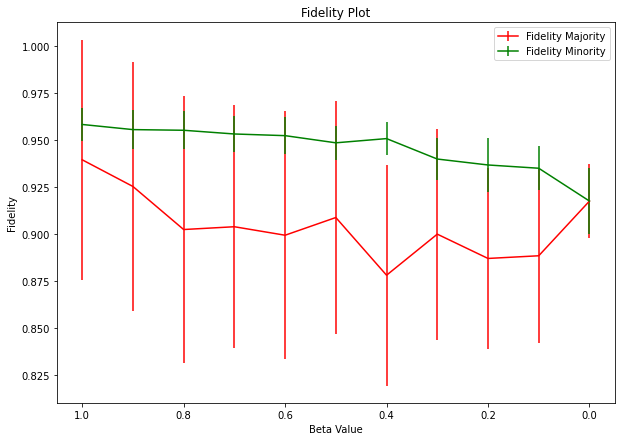

In [28]:
plt.figure(figsize=(10,7))
plt.errorbar(bias_amts, 1-mean_fidel_maj, yerr = y_err_fidel_maj, label = 'Fidelity Majority', color = "red")
plt.errorbar(bias_amts, 1-mean_fidel_min, yerr = y_err_fidel_min, label = 'Fidelity Minority', color = "green")
plt.xlabel("Beta Value")
plt.ylabel("Fidelity")
plt.xlim(1.05, -0.05)
plt.legend()
plt.title("Fidelity Plot")
plt.show()

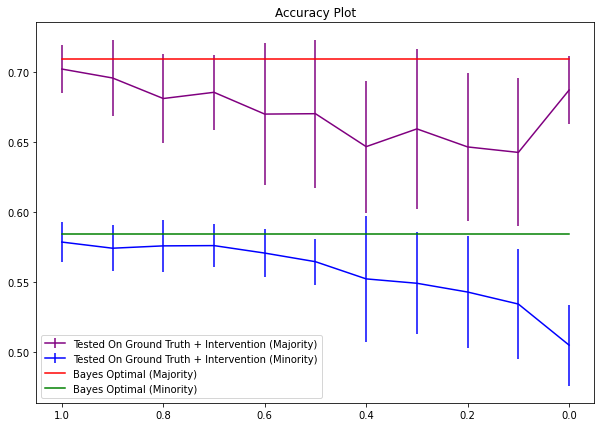

In [29]:
plt.figure(figsize=(10,7))
plt.errorbar(bias_amts, mean_true_mitigated_maj, yerr= y_err_true_mitigated_maj, label = 'Tested On Ground Truth + Intervention (Majority)', color = "purple")
plt.errorbar(bias_amts, mean_true_mitigated_min, yerr= y_err_true_mitigated_min, label = 'Tested On Ground Truth + Intervention (Minority)', color = "blue")
#plt.errorbar(bias_amts, mean_true_maj, yerr= y_err_true_mitigated_maj, label = 'Tested On Ground Truth + NO Intervention (Majority)', color = "pink")
#plt.errorbar(bias_amts, mean_true_min, yerr= y_err_true_mitigated_min, label = 'Tested On Ground Truth + NO Intervention (Minority)', color = "black")
plt.errorbar(bias_amts, mean_bayes_accuracy_on_true_maj, label = 'Bayes Optimal (Majority)', color = 'red')
plt.errorbar(bias_amts, mean_bayes_accuracy_on_true_min, label = 'Bayes Optimal (Minority)', color = 'green')
plt.legend()
plt.xlim(1.05, -0.05)
plt.title("Accuracy Plot")
plt.show()